### Credit card default data set from UCI-ML Repository [link to dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)
#### A classification problem with: 
- 30,000 client data, 
- 23 variables (or inputs), 
- 1 binary output: Default payment (Yes=1, No=0)
- no missing values

### PROBLEM STATEMENT: Predict the probability that a client will default

### **NOTE:** First, check the exploratory data analysis notebook

### Logistic regression, despite the term "regression", is **not** a regression algorithm. It is a **classification** algorithm. 
### LogReg models the relationship between one or more inputs to a binary (0-1) output? For example, in the credit card problem, defaulting payment is represented as 1 (implying 100\% probability that a client does not pay off the balance), and not defaulting is represented as 0 (in other words 0\% probability that a client defaults). 
### With past data, we can be **absolutely certain** (i.e. 0 or 100\%) about the payment status. If we want to predict the **future behaviour** of a client we have to think **probabilistically**. 
### E.g. Tyrion has 0.1\% probability of defaulting because he has paid fully his CC his whole life, except a couple of times that he forgot. Why do I trust this statement instead of 0\% probability of defaulting? First, unexpected things can always happen. The value of 0.1\% a model may predict simply tells me that: good clients who look like Tyrion (i.e. always pay off their debt, he is a Lannister) fail to pay their debt at a rate of 1 out of 1,000 (i.e. 0.1\%)


### The [LogReg](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) models the input(s)-output relationship based on the sigmoid equation: $P(x) = \frac{1}{1+e^{-(mx+b)}}$ where P(x) is the output as probability between 0 and 1, x is the vector of inputs, m and b are the slope and intercept parameters calculated from fitting the data.
<img src="LogReg.png" width=500  />

In [1]:
# Import libraries and settings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams.update({'font.size': 16})
import seaborn as sns

In [2]:
# Import data and rename column
cc_data = pd.read_excel('cc_data_uci.xls')
cc_data.rename(columns={'default payment next month': 'OUTPUT'}, inplace = True)

# Separate inputs: X and output:y
X = cc_data.drop(['OUTPUT'], axis = 1)
y = cc_data['OUTPUT']

cc_data.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,OUTPUT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0


### Notice the vast difference in scales among the different inputs? 
- LIMIT_BAL, BILL_AMT is in the order of 1,000,000, whereas SEX, EDUCATION, MARRIAGE indicators are in the order of 1.
- This will create enormous numerical problems when we try to fit the data to the sigmoid function. Why? 
- Fitting data implies that a [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) will be used to minimize some error between the output and the line of fit. Gradient descent problems with large scale differences are ill-defined.

In [3]:
cc_data.max()

LIMIT_BAL    1000000
SEX                2
EDUCATION          6
MARRIAGE           3
AGE               79
PAY_0              8
PAY_2              8
PAY_3              8
PAY_4              8
PAY_5              8
PAY_6              8
BILL_AMT1     964511
BILL_AMT2     983931
BILL_AMT3    1664089
BILL_AMT4     891586
BILL_AMT5     927171
BILL_AMT6     961664
PAY_AMT1      873552
PAY_AMT2     1684259
PAY_AMT3      896040
PAY_AMT4      621000
PAY_AMT5      426529
PAY_AMT6      528666
OUTPUT             1
dtype: int64

### SOLUTION: Scale the inputs. This is an **essential** part of [**pre-processing**](https://scikit-learn.org/stable/modules/preprocessing.html). Here, we use the simplest pre-processing, the [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from Sklearn. The Standard Scaler performs the following transformation for every column/feature: removes the mean and scales to unit variance or $ z = \frac{\text{x - mean}}{\text{standard deviation}}$

In [5]:
# Create the instance of the scaler
scaler = StandardScaler()
# Transform the inputs X
X_scaled = scaler.fit_transform(X)
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

### Split in train (10,000) and test (20,000) data points

In [9]:
# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=2/3, random_state=0)
X_test.shape

(20000, 23)

### Create an instance of LogReg and fit the data (for now leave all settings to default; with LASSO we will review them)

In [10]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Extract the 23 values of **m** (plot), the coefficients of the LogReg and the **intercept** b. Reminder: $P(x) = \frac{1}{1+e^{-(m_1x_1 + m_2x_2 + ... +b)}}$

In [11]:
m = LogReg.coef_
m

array([[-0.131437  , -0.06379497, -0.10700139, -0.16055352,  0.064128  ,
         0.56986993,  0.15678798,  0.0753623 , -0.0469036 ,  0.02414902,
         0.0576594 , -0.35630697, -0.15193838,  0.10771778,  0.25726587,
        -0.13553109,  0.16523905, -0.18791308, -0.16285593, -0.14986014,
        -0.01394155, -0.08209428, -0.08075622]])

In [12]:
b = LogReg.intercept_
b

array([-1.42716071])

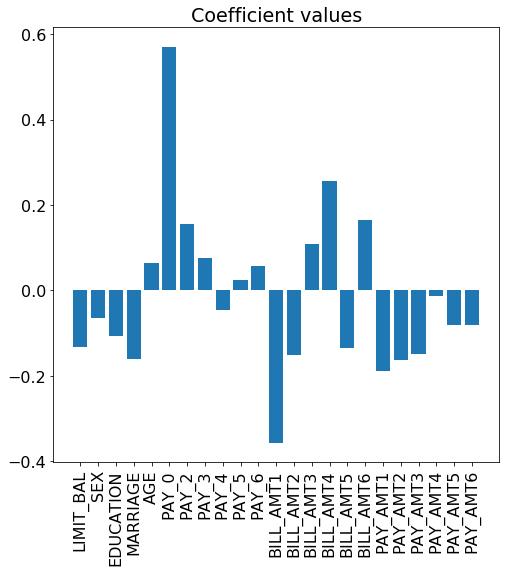

In [13]:
# Create plot
plt.figure()
# Create plot title
plt.title("Coefficient values")
# Add bars
plt.bar(range(X.shape[1]), m[0])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
# Show plot
plt.show()

### An important note on how we can practically apply the knowledge from this model.
- You can get the model to predict whether a new client will be 0 or 1 (pay or default). This is done with the method **predict**.
- A business objective typically involves quantifying risk (e.g. risk of a machine part breaking, a product failing, a customer defaulting, having cancer)
- Therefore, the business may be interested in predicting the probability of a client defaulting. This is done with the method **predict_proba**.
- The **predict_proba** method plugs in the input values x for every client into the sigmoid function and calculates the probability P(x).

### Scenario 1: Predict the class of customers in the test set. For each client, give a 0 or 1.

In [14]:
y_test_predicted = LogReg.predict(X_test)
y_test_predicted

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [15]:
# How many 0s an 1s does the model predict in the test set?
unique_elements, counts_elements = np.unique(y_test_predicted, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [18576  1424]]


### Scenario 2: Predict the probability of defaulting in the test set. For each client, give probability of 0 and 1 (they add up to 100%)

In [16]:
y_test_proba = LogReg.predict_proba(X_test)
y_test_proba

array([[0.49287804, 0.50712196],
       [0.74635823, 0.25364177],
       [0.66297759, 0.33702241],
       ...,
       [0.76647403, 0.23352597],
       [0.8485509 , 0.1514491 ],
       [0.47006137, 0.52993863]])

### **QUESTION:** How do you think the class is predicted in Scenario 1?
### Plot the distribution of the probabilities in the test data set.

Text(8.280000000000001, 0.5, 'Counts of clients')

<Figure size 360x360 with 0 Axes>

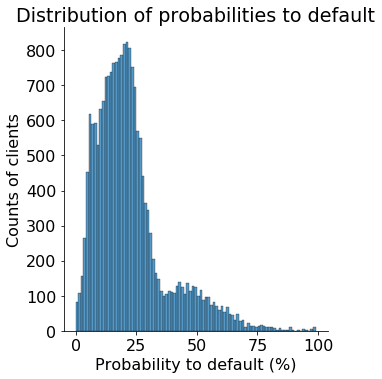

In [17]:
plt.figure(figsize=(5,5))
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to default')
plt.xlabel('Probability to default (%)')
plt.ylabel('Counts of clients')

### Some basic performance metrics: The confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_predicted)
print(cm)

[[15236   401]
 [ 3340  1023]]


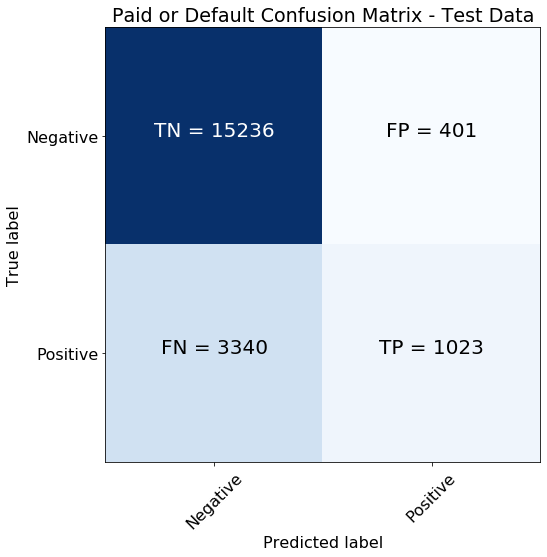

In [19]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Paid or Default Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

### Classification report + Accuracy score

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_test, y_test_predicted, target_names = ['Paid', 'Default']))

              precision    recall  f1-score   support

        Paid       0.82      0.97      0.89     15637
     Default       0.72      0.23      0.35      4363

    accuracy                           0.81     20000
   macro avg       0.77      0.60      0.62     20000
weighted avg       0.80      0.81      0.77     20000



In [21]:
accuracy_score(y_test, y_test_predicted, normalize = True) # Change normalize = True/False as well. DIAGONAL OVER ALL

0.81295

### Let's build the ROC curves from scratch

In [22]:
from sklearn.metrics import roc_curve, auc

In [23]:
# Scores for train set
scores_train = LogReg.predict_proba(X_train)[:, 1]
# Scores for test set
scores_test = LogReg.predict_proba(X_test)[:, 1]

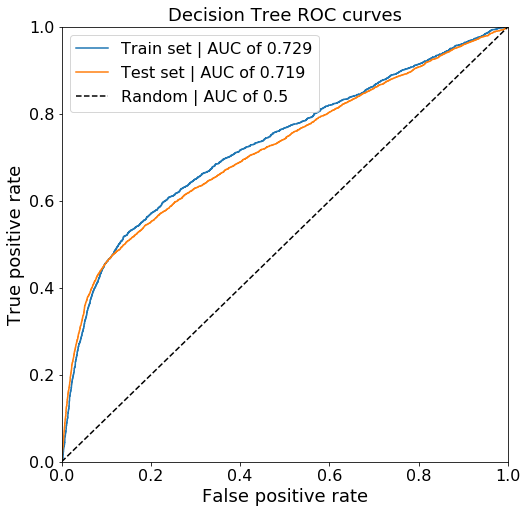

In [24]:
# ROC Calc Train set
fpr_train, tpr_train, _ = roc_curve(y_train, scores_train)
# ROC Calc Test set
fpr_test, tpr_test, _ = roc_curve(y_test, scores_test)
# AUC Calc
auc_train = auc(fpr_train, tpr_train)
# AUC Calc
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

### **Decision Boundary:** For any classification problem (binary or multi-class) there is a line or plane (or hypersurface generally) that separates the input space into regions of different classes. Logistic regression is **linear classification** method and the decision boundary is calculated by replacing $P(x) = 0.5 = \frac{1}{1+e^{-(m_1x_1 + m_2x_2 + ... +b)}}$
### The coefficients with the highest values are PAY_0 (5th column) and BILL_AMT1 (11th column). Here, we will plot the decision boundary in the plane of these two variables. Explore the min and max values of these two variables and draw the contour of the probabilities on the plane, along with some labeled data.

In [25]:
X_scaled.min(axis=0) # Confirm these values MIN PAY_0: -1.76484282 and MIN BILL_AMT1: -2.94431195

array([-1.21379411, -1.23432296, -2.34474266, -2.97314734, -1.57147887,
       -1.76484282, -1.55887596, -1.53219171, -1.52194355, -1.53004603,
       -1.48604076, -2.94431195, -1.671375  , -2.94567215, -3.31504796,
       -2.00087367, -6.35524709, -0.34194162, -0.25698952, -0.29680127,
       -0.30806256, -0.31413612, -0.29338206])

In [26]:
X_scaled.max(axis=0) # Confirm these values MAX PAY_0: 7.13367389 and MAX BILL_AMT1: 12.4029635 

array([ 6.41652838,  0.81016074,  5.2469701 ,  2.7744096 ,  4.72072881,
        7.13367389,  6.79418438,  6.82309081,  7.03150467,  7.29476672,
        7.20984992, 12.4029635 , 13.13359571, 23.31819872, 13.18668626,
       14.58743208, 15.49528081, 52.39921478, 72.84298641, 50.59528115,
       39.3321786 , 27.60362636, 29.44509799])

### Create a 10x10 grid between the min and max values that we will use to estimate the probabilities for the contour plot.

In [27]:
xx, yy = np.mgrid[-2:8:1.1111, -3:13:1.75] # The steps 1.1111 and 1.75 were selected to create a 10x10 grid
grid = np.c_[xx.ravel(), yy.ravel()]
grid.shape # Confirm that grid shape is 10x10

(100, 2)

### We need all 23 variables to predict the probability over the 10x10 grid of PAY_0 and BILL_AMT1. What values should we use for the other 21 variables? I pick the median of each column. Create 100 rows so that they much the 10x10 grid.

In [28]:
# np.ones is a table full of ones with 100x23 dimension
# np.median calculates the median of every column in the X_train along axis=0 (i.e. column)
median_inputs = np.ones((100, 23)) * np.median(X_train, axis=0) 
pd.DataFrame(median_inputs) # Convert to pandas is not necessary. Just doing it here to have a nice view of the table

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
1,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
2,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
3,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
4,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
96,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
97,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004
98,-0.211833,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.384778,-0.374923,-0.364002,-0.363655,-0.21467,-0.170012,-0.192494,-0.212313,-0.215465,-0.209004


In [29]:
# Then, we replace the 5th and 11th column with the values of the grid
median_inputs[:,5] = grid[:,0]
median_inputs[:,11] = grid[:,1]
df = pd.DataFrame(median_inputs).iloc[:13,:12] # Convert to pandas is not necessary. Just doing it here to have a nice view of the table
df.style.apply(lambda x: ['background: grey' if (x.name == 5)|(x.name == 11)  else '' for i in x])

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,-3.000000
1,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,-1.250000
2,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,0.500000
3,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,2.250000
4,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,4.000000
5,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,5.750000
6,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,7.500000
7,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,9.250000
8,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,11.000000
9,-0.211833,0.810161,0.185828,0.858557,-0.161156,-2.000000,0.111736,0.138865,0.188746,0.234917,0.253137,12.750000


### Score the artificial data on the grid

In [30]:
probs = LogReg.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

### Plot the contour for the grid and a scatter of 50 original datapoints from X_train. 
- The decision boundary is the thin **white** slice, where P(y=1) = 0.50
- Darker **blue** indicates higher probability to default, i.e. 1.0
- Darker **red** indicates lower probability to default, i.e. 0.0

[(-3, 13),
 Text(0, 0.5, 'BILL_AMT1 scaled'),
 (-2, 8),
 Text(0.5, 0, 'PAY_0 scaled'),
 None]

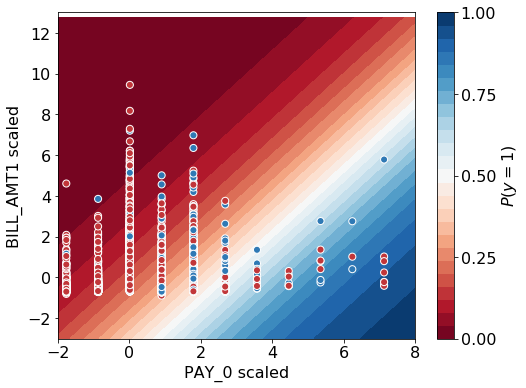

In [31]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train[50:,5], X_train[50:, 11], c=y_train[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 8), ylim=(-3, 13),
       xlabel="PAY_0 scaled", ylabel="BILL_AMT1 scaled")

### What is the frequency of default for different values of PAY_0? Use groupby and aggregation to calculate.
### Reminder: PAY_0 values of -2, -1, 0 mean that the credit was paid on time.
### PAY_0 values greater than 0 mean that the payments were delayed by the respective number of months

In [32]:
PAY_0_groups = cc_data.groupby('PAY_0').agg({"OUTPUT": ["sum", "count"]}).rename(columns={"sum": "DEFAULTS_COUNT",
                                                                                          "count": "TOTAL_CLIENTS"})
PAY_0_groups.columns = PAY_0_groups.columns.droplevel(0) # This is to drop the multilevel index OUTPUT
PAY_0_groups['FREQUENCY_OF_DEFAULT'] = round(PAY_0_groups["DEFAULTS_COUNT"]/PAY_0_groups["TOTAL_CLIENTS"]*100, 0)

PAY_0_groups

,DEFAULTS_COUNT,TOTAL_CLIENTS,FREQUENCY_OF_DEFAULT
PAY_0,,,
-2,365,2759,13.0
-1,954,5686,17.0
0,1888,14737,13.0
1,1252,3688,34.0
2,1844,2667,69.0
3,244,322,76.0
4,52,76,68.0
5,13,26,50.0
6,6,11,55.0
